# Exercise B
The dataset ends before the year 2019 is over, but we’d like to know how we might perform for
the remainder of the year.
- Build a model to forecast daily revenue for the remainder of 2019. You can use any method you prefer, but please report on your accuracy using a training and test set.
- Plot both the forecasted and actual revenue on a chart.

In this exercise, I fit a SARIMA model to forecast the daily revenue from  2019-12-14-2019-12-31

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'Black'

## Read in data

In [2]:
line_items = pd.read_csv('line_items.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

## Join tables

In [3]:
joined_tables1 = orders.merge(line_items, how='outer', on='order_number') \
    .merge(products, how='outer', on='product_id')

In [4]:
missing_line_item_number = joined_tables1.loc[joined_tables1.line_item_number.isnull()].shape[0]
print(round(missing_line_item_number/orders.shape[0] *100,2), '% orders are missing line_items_number')

4.47 % orders are missing line_items_number


In [5]:
# drop missings 
joined_tables1 = joined_tables1[joined_tables1.line_item_number.notnull()].reset_index()

In [6]:
# keep date
joined_tables1['ordered_date'] = joined_tables1.ordered_at_utc.str[:10]

In [7]:
joined_tables1.head()

,index,order_number,ordered_at_utc,customer_uuid,discount,line_item_number,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost,ordered_date
0,0,148320207,2018-08-10 18:36:00,7.407832e+12,0.02,181686513.0,7.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2018-08-10
1,1,152403312,2018-08-29 18:13:00,4.083313e+12,0.06,188522363.0,9.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2018-08-29
2,2,181312465,2018-11-20 07:42:00,4.584988e+12,0.06,226444646.0,9.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2018-11-20
3,3,77671616,2017-10-06 21:50:00,4.183541e+12,0.08,91741819.0,9.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2017-10-06
4,4,152650897,2018-09-04 01:16:00,9.182046e+11,0.10,191205274.0,6.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2018-09-04


## Calculate daily revenue

In [11]:
def f(x):
    d = {}
    d['revenue'] = ((1-x['discount']) * x['units_sold'] * x['selling_price']).sum()
    return pd.Series(d, index=['revenue'])
daily_revenue = joined_tables1.groupby('ordered_date').apply(f).reset_index()
daily_revenue['ordered_date'] = pd.to_datetime(daily_revenue['ordered_date'], format='%Y-%m-%d')
daily_revenue.head()

,ordered_date,revenue
0,2016-12-13,8693.6858
1,2016-12-14,12721.9332
2,2016-12-15,5893.5212
3,2016-12-16,4128.6290
4,2016-12-17,1964.9728


## SARIMA model

#### Imput 0 for the day missing revenue

In [12]:
daily_revenue = daily_revenue.set_index(['ordered_date'])

# generate all dates
all_dates_list = pd.date_range('2016-12-13','2019-12-13',freq='d')
all_dates = pd.DataFrame(all_dates_list, columns=['ordered_date'])
all_dates = all_dates.set_index(['ordered_date'])

# imput 0 for missing revenue day
daily_revenue = daily_revenue.merge(all_dates, how='outer', on='ordered_date')
daily_revenue[daily_revenue.revenue.isnull()] = 0
daily_revenue.sort_index(inplace=True)

#### Split to train and test data set

In [14]:
train = daily_revenue[daily_revenue.index < '2019-11-01']
test = daily_revenue[daily_revenue.index >= '2019-11-01']

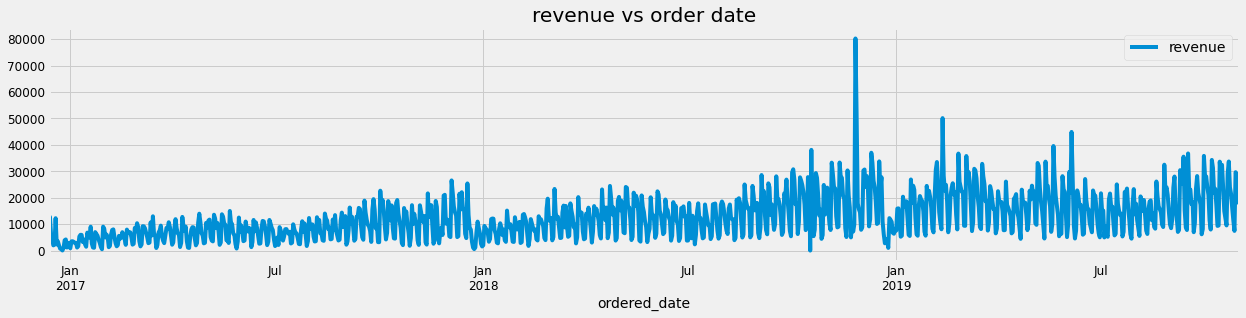

In [15]:
y = train.copy()
y.plot(figsize=(19, 4))
plt.title('revenue vs order date')
plt.show()

#### Decompose the time-series into three distinct components: trend, seasonality, and noise.

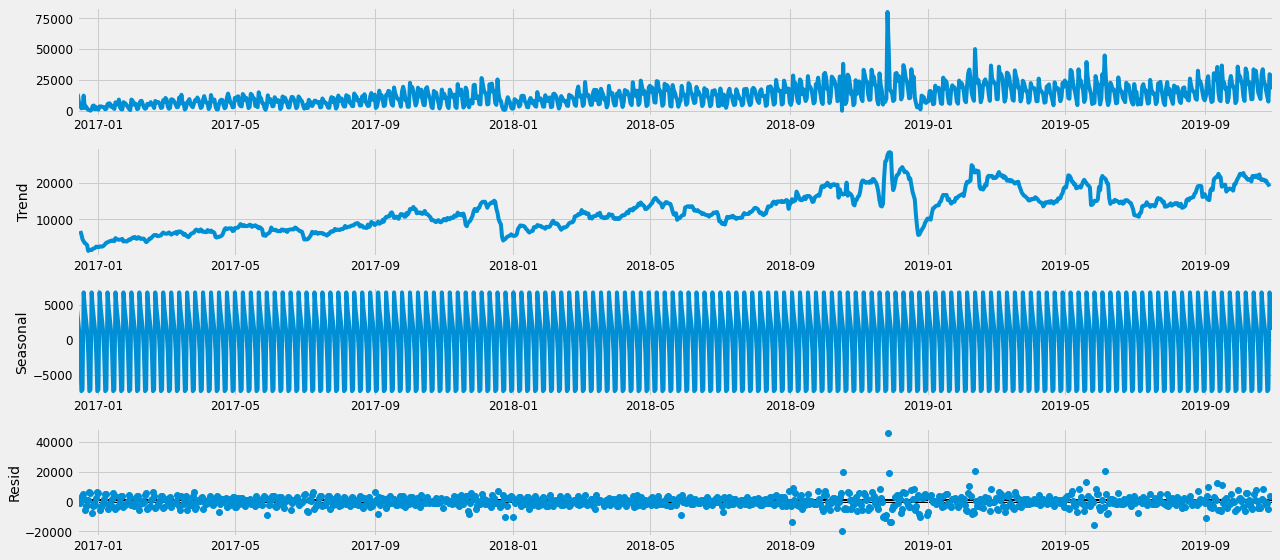

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y.asfreq('D'), model = 'additive')
fig = decomposition.plot()
plt.show()

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

#### SARIMA model selection by using AIC

In [18]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:23218.504995101146
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:22491.335127388462
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:20986.911566416864
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:20472.680238734454
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:20978.096070906253
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:20603.969817587233
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:20625.965264076272
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:20462.778096760834
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:22421.906465616823
ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:22193.215979610693
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:20930.480579873547
ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:20432.827534938442
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:22027.958340744983
ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:21936.496630535505
ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:20603.79791869052
ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:20431.371605864675
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:21868.088782845367
ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:21489.30867640984
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 -

#### Fit the model

In [30]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9263      0.027     33.702      0.000       0.872       0.980
ma.L1         -0.7355      0.034    -21.535      0.000      -0.802      -0.669
ma.S.L7       -0.9005      0.010    -87.410      0.000      -0.921      -0.880
sigma2      2.945e+07   3.61e-10   8.15e+16      0.000    2.95e+07    2.95e+07


#### model diagnostic

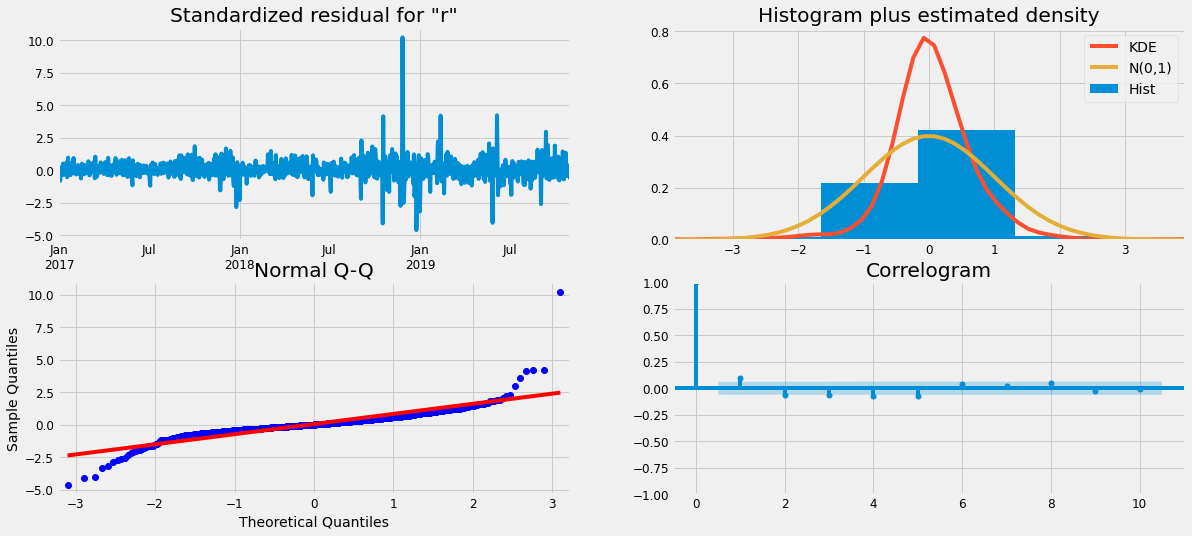

In [31]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Validation - in sample prediction

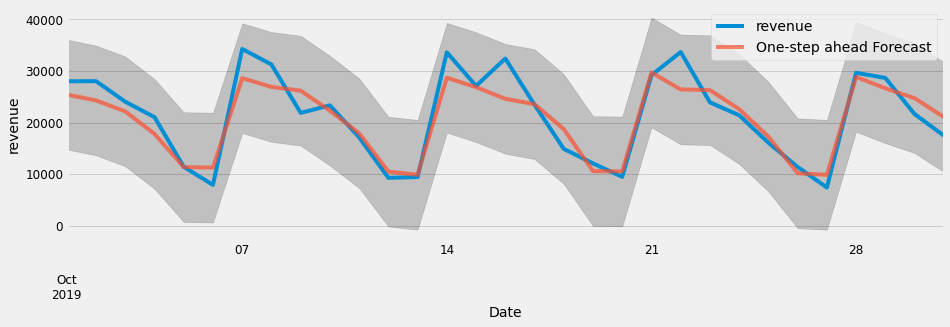

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2019-10-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2019-10':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-09-01':]['revenue']
mse = (((y_forecasted)- (y_truth)) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 10247672.64
The Root Mean Squared Error is 3201.2


#### Validation - out of sample forecast

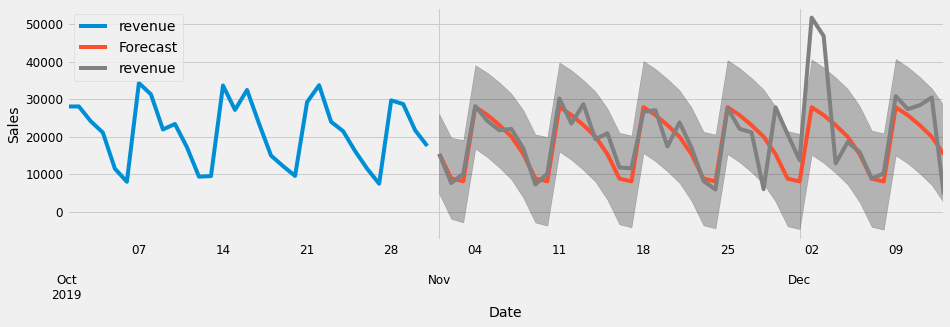

In [39]:
pred_uc = results.get_forecast(steps=43)
pred_ci = pred_uc.conf_int()
ax = y['2019-10':].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
test['2019-10':].plot(label='observed', ax=ax, color='grey')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [40]:
y_forecasted = pred_uc.predicted_mean
y_truth = test['revenue']
mse = (((y_forecasted)- (y_truth)) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 49052307.16
The Root Mean Squared Error is 7003.74


#### Forecast how we might perform for the remainder of the year 2019.

In [42]:
mod = sm.tsa.statespace.SARIMAX(daily_revenue,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9252      0.018     52.170      0.000       0.890       0.960
ma.L1         -0.7408      0.022    -33.989      0.000      -0.784      -0.698
ma.S.L7       -0.9069      0.006   -145.169      0.000      -0.919      -0.895
sigma2      1.927e+07    3.6e-10   5.35e+16      0.000    1.93e+07    1.93e+07


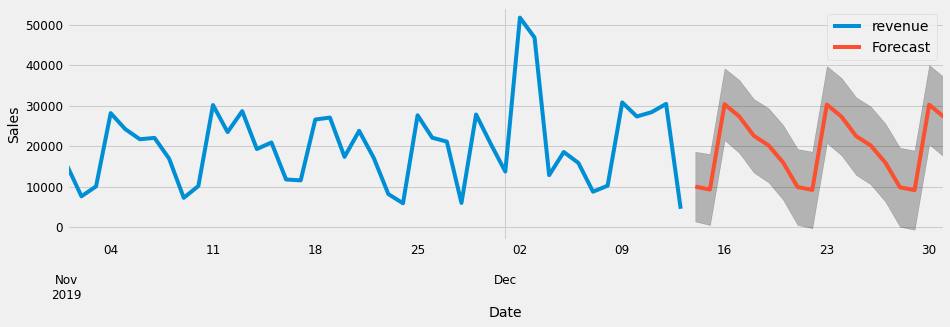

In [44]:
pred_uc = results.get_forecast(steps=18)
pred_ci = pred_uc.conf_int()
ax = daily_revenue['2019-11':].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

### The end